# Проект: классификация

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [89]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [90]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [91]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [92]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def to_float(line):
    if type(line) is float:
        pass
    else: return float(line.replace('$', '').replace(',00', '').replace(' ', ''))

df['balance'] = df['balance'].apply(to_float)

print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [93]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
values = {
    'balance': df['balance'].median()
}

df = df.fillna(values)

print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [94]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

df['job'].replace(to_replace='unknown', value=mode_job, inplace=True)
df['education'].replace(to_replace='unknown', value=mode_education, inplace=True)

mask_mode = (df['job'] == mode_job) & (df['education'] == mode_education)

print(round(df[mask_mode]['balance'].mean(), 3))

1598.883


### Задание 6

In [95]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr_mod(data, feature, left = 1.5, right = 1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    
    print(round(lower_bound),round(upper_bound))
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

_, df = outliers_iqr_mod(df, 'balance')

df.shape

-2241 4063


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

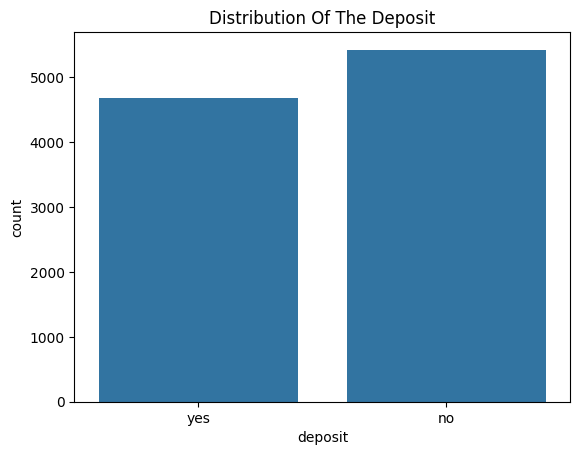

In [96]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df['deposit'].value_counts())

pl = sns.countplot(x=df['deposit'])
pl.set_title("Distribution Of The Deposit")
plt.show()

Целевой признак в целом сбалансирован.

### Задания 2 и 3

In [97]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(df.describe(include=['int64', 'float']))

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [98]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


#### Графики

#### Описание

### Задание 6

In [99]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df.groupby('poutcome')['deposit'].value_counts(normalize=True)*100

poutcome  deposit
failure   no         50.676285
          yes        49.323715
other     yes        55.093555
          no         44.906445
success   yes        91.111111
          no          8.888889
unknown   no         60.264201
          yes        39.735799
Name: proportion, dtype: float64

### Задание 7

In [100]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df.groupby('deposit')['month'].value_counts(normalize=True)*100

deposit  month
no       may      32.743363
         jul      15.412979
         aug      14.288348
         jun      11.172566
         nov       8.407080
         feb       5.955015
         apr       5.844395
         jan       3.576696
         oct       1.143068
         sep       0.848083
         mar       0.442478
         dec       0.165929
yes      may      17.966247
         aug      13.031404
         jul      12.433241
         apr      10.959197
         jun      10.638752
         feb       8.246101
         nov       6.921598
         oct       5.832087
         sep       4.956206
         mar       4.550310
         jan       2.670370
         dec       1.794488
Name: proportion, dtype: float64

### Задание 8

In [101]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def remake_age(num):
    if num < 30:    return '<30'
    elif num >= 30 and num < 40: return '30-40'
    elif num >= 40 and num < 50: return '40-50'
    elif num >= 50 and num < 60: return '50-60'
    elif num >= 60: return '60+'
    
df['age_category'] = df['age'].apply(remake_age)

mask_deposit_yes = df['deposit'] == 'yes'
mask_deposit_no = df['deposit'] == 'no'

df[mask_deposit_yes]['age_category'].value_counts() - df[mask_deposit_no]['age_category'].value_counts()

age_category
30-40   -529
40-50   -506
50-60   -314
60+      339
<30      267
Name: count, dtype: int64

### Задания 9 и 10

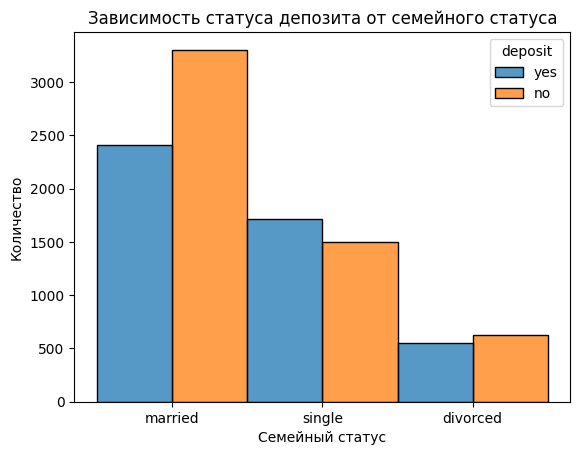

In [102]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure()
pl=sns.histplot(x=df["marital"], hue=df['deposit'], multiple='dodge')
pl.set_title("Зависимость статуса депозита от семейного статуса")
pl.set_xlabel("Семейный статус")
pl.set_ylabel("Количество")
plt.show()

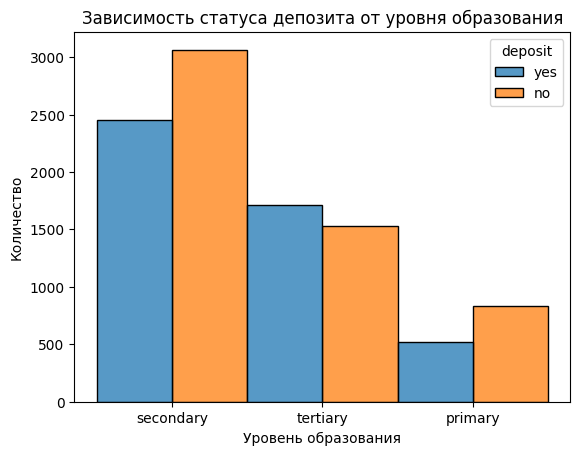

In [103]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
plt.figure()
pl=sns.histplot(x=df["education"], multiple='dodge', hue=df['deposit'])
pl.set_title("Зависимость статуса депозита от уровня образования")
pl.set_xlabel("Уровень образования")
pl.set_ylabel("Количество")
plt.show()

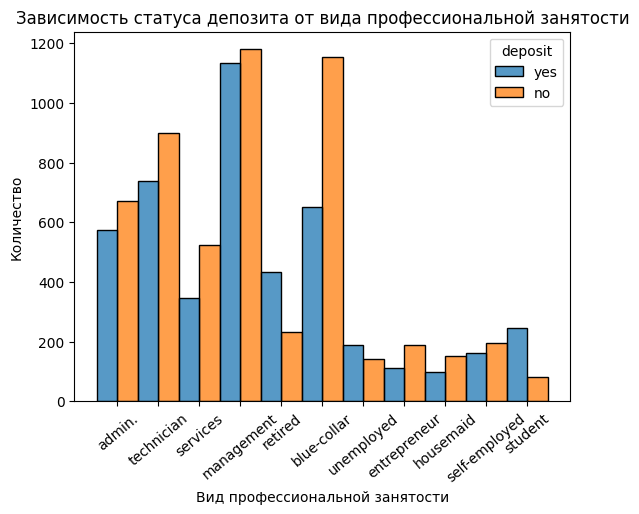

In [104]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure()
pl=sns.histplot(x=df["job"], hue=df['deposit'], multiple='dodge')
pl.set_title("Зависимость статуса депозита от вида профессиональной занятости")
pl.set_xlabel("Вид профессиональной занятости")
plt.xticks(rotation=40)
pl.set_ylabel("Количество")
plt.show()

### Задание 11

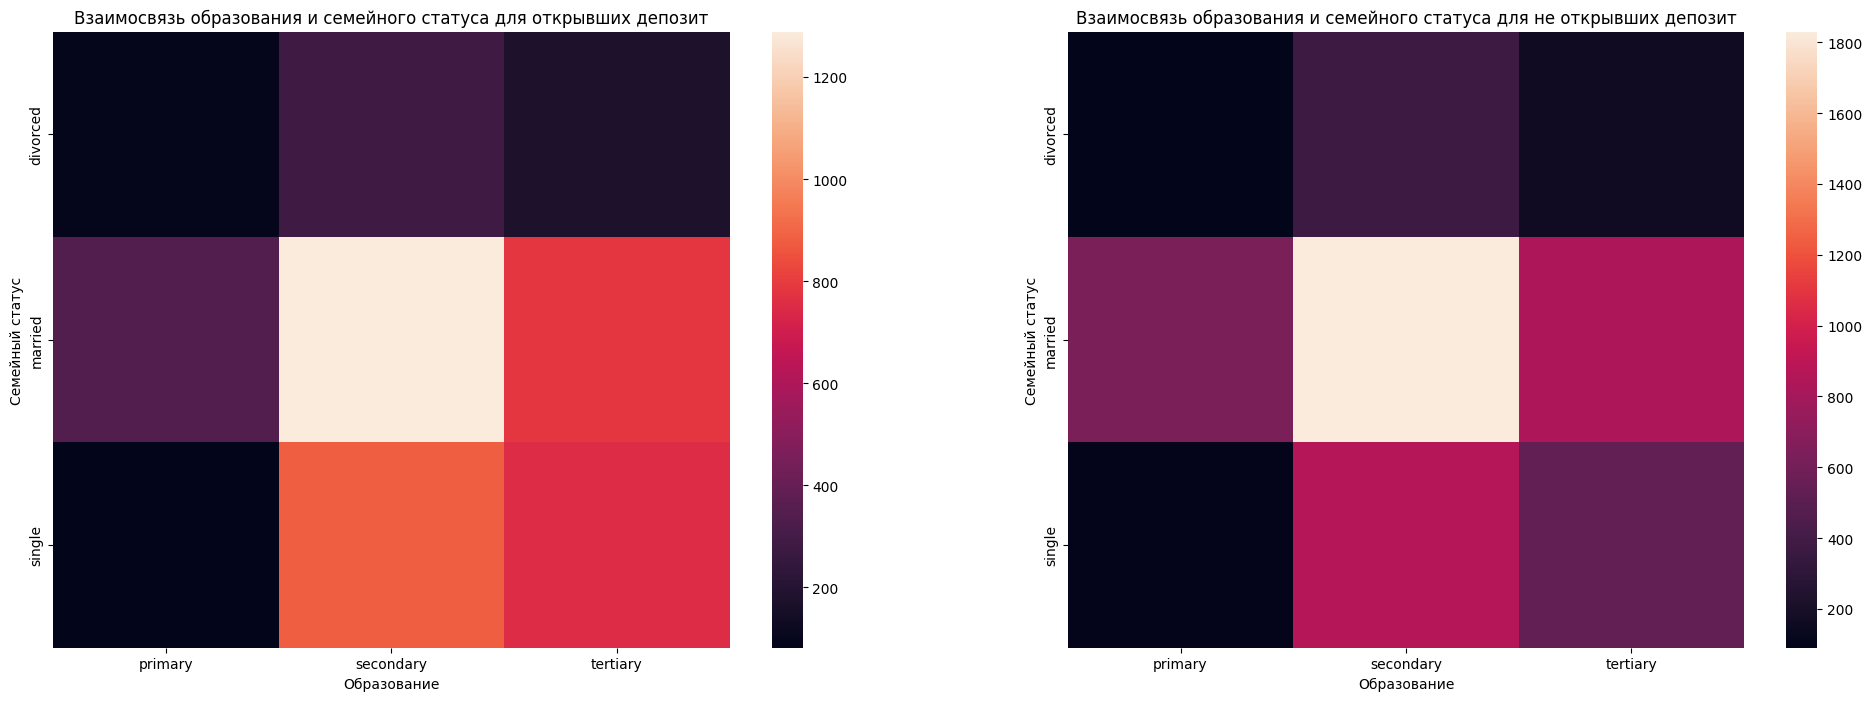

In [105]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_grouped_pos = df[mask_deposit_yes].groupby(['marital', 'education']).size().reset_index(name='count')
df_grouped_pos = df_grouped_pos.pivot(index='marital', columns='education', values='count')

df_grouped_neg = df[mask_deposit_no].groupby(['marital', 'education']).size().reset_index(name='count')
df_grouped_neg = df_grouped_neg.pivot(index='marital', columns='education', values='count')

fig, axes = plt.subplots(ncols=2, figsize=(24, 8))

sns.heatmap(df_grouped_pos, ax=axes[0])
axes[0].set_title("Взаимосвязь образования и семейного статуса для открывших депозит")
axes[0].set_xlabel("Образование")
axes[0].set_ylabel("Семейный статус")

sns.heatmap(df_grouped_neg, ax=axes[1])
axes[1].set_title("Взаимосвязь образования и семейного статуса для не открывших депозит")
axes[1].set_xlabel("Образование")
axes[1].set_ylabel("Семейный статус")

plt.show()

## Часть 3: преобразование данных

### Задание 1

In [106]:
# преобразуйте уровни образования
LE = preprocessing.LabelEncoder()
df['education'] = LE.fit_transform(df['education'])

print(df['education'].sum())

df['age_category'] = LE.fit_transform(df['age_category'])

11995


### Задания 2 и 3

In [107]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'].replace(to_replace={'yes': 1, 'no': 0}, inplace=True)
display(df['deposit'].describe())

df['default'].replace(to_replace={'yes': 1, 'no': 0}, inplace=True)
df['housing'].replace(to_replace={'yes': 1, 'no': 0}, inplace=True)
df['loan'].replace(to_replace={'yes': 1, 'no': 0}, inplace=True)

print(round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3))

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

0.635


### Задание 4

In [108]:
# создайте дамми-переменные
categorical_columns_names = [ 'job', 'marital', 'contact', 'month', 'poutcome' ]
df = pd.get_dummies(df, columns = categorical_columns_names)

df.shape[1]

46

### Задания 5 и 6

<Axes: >

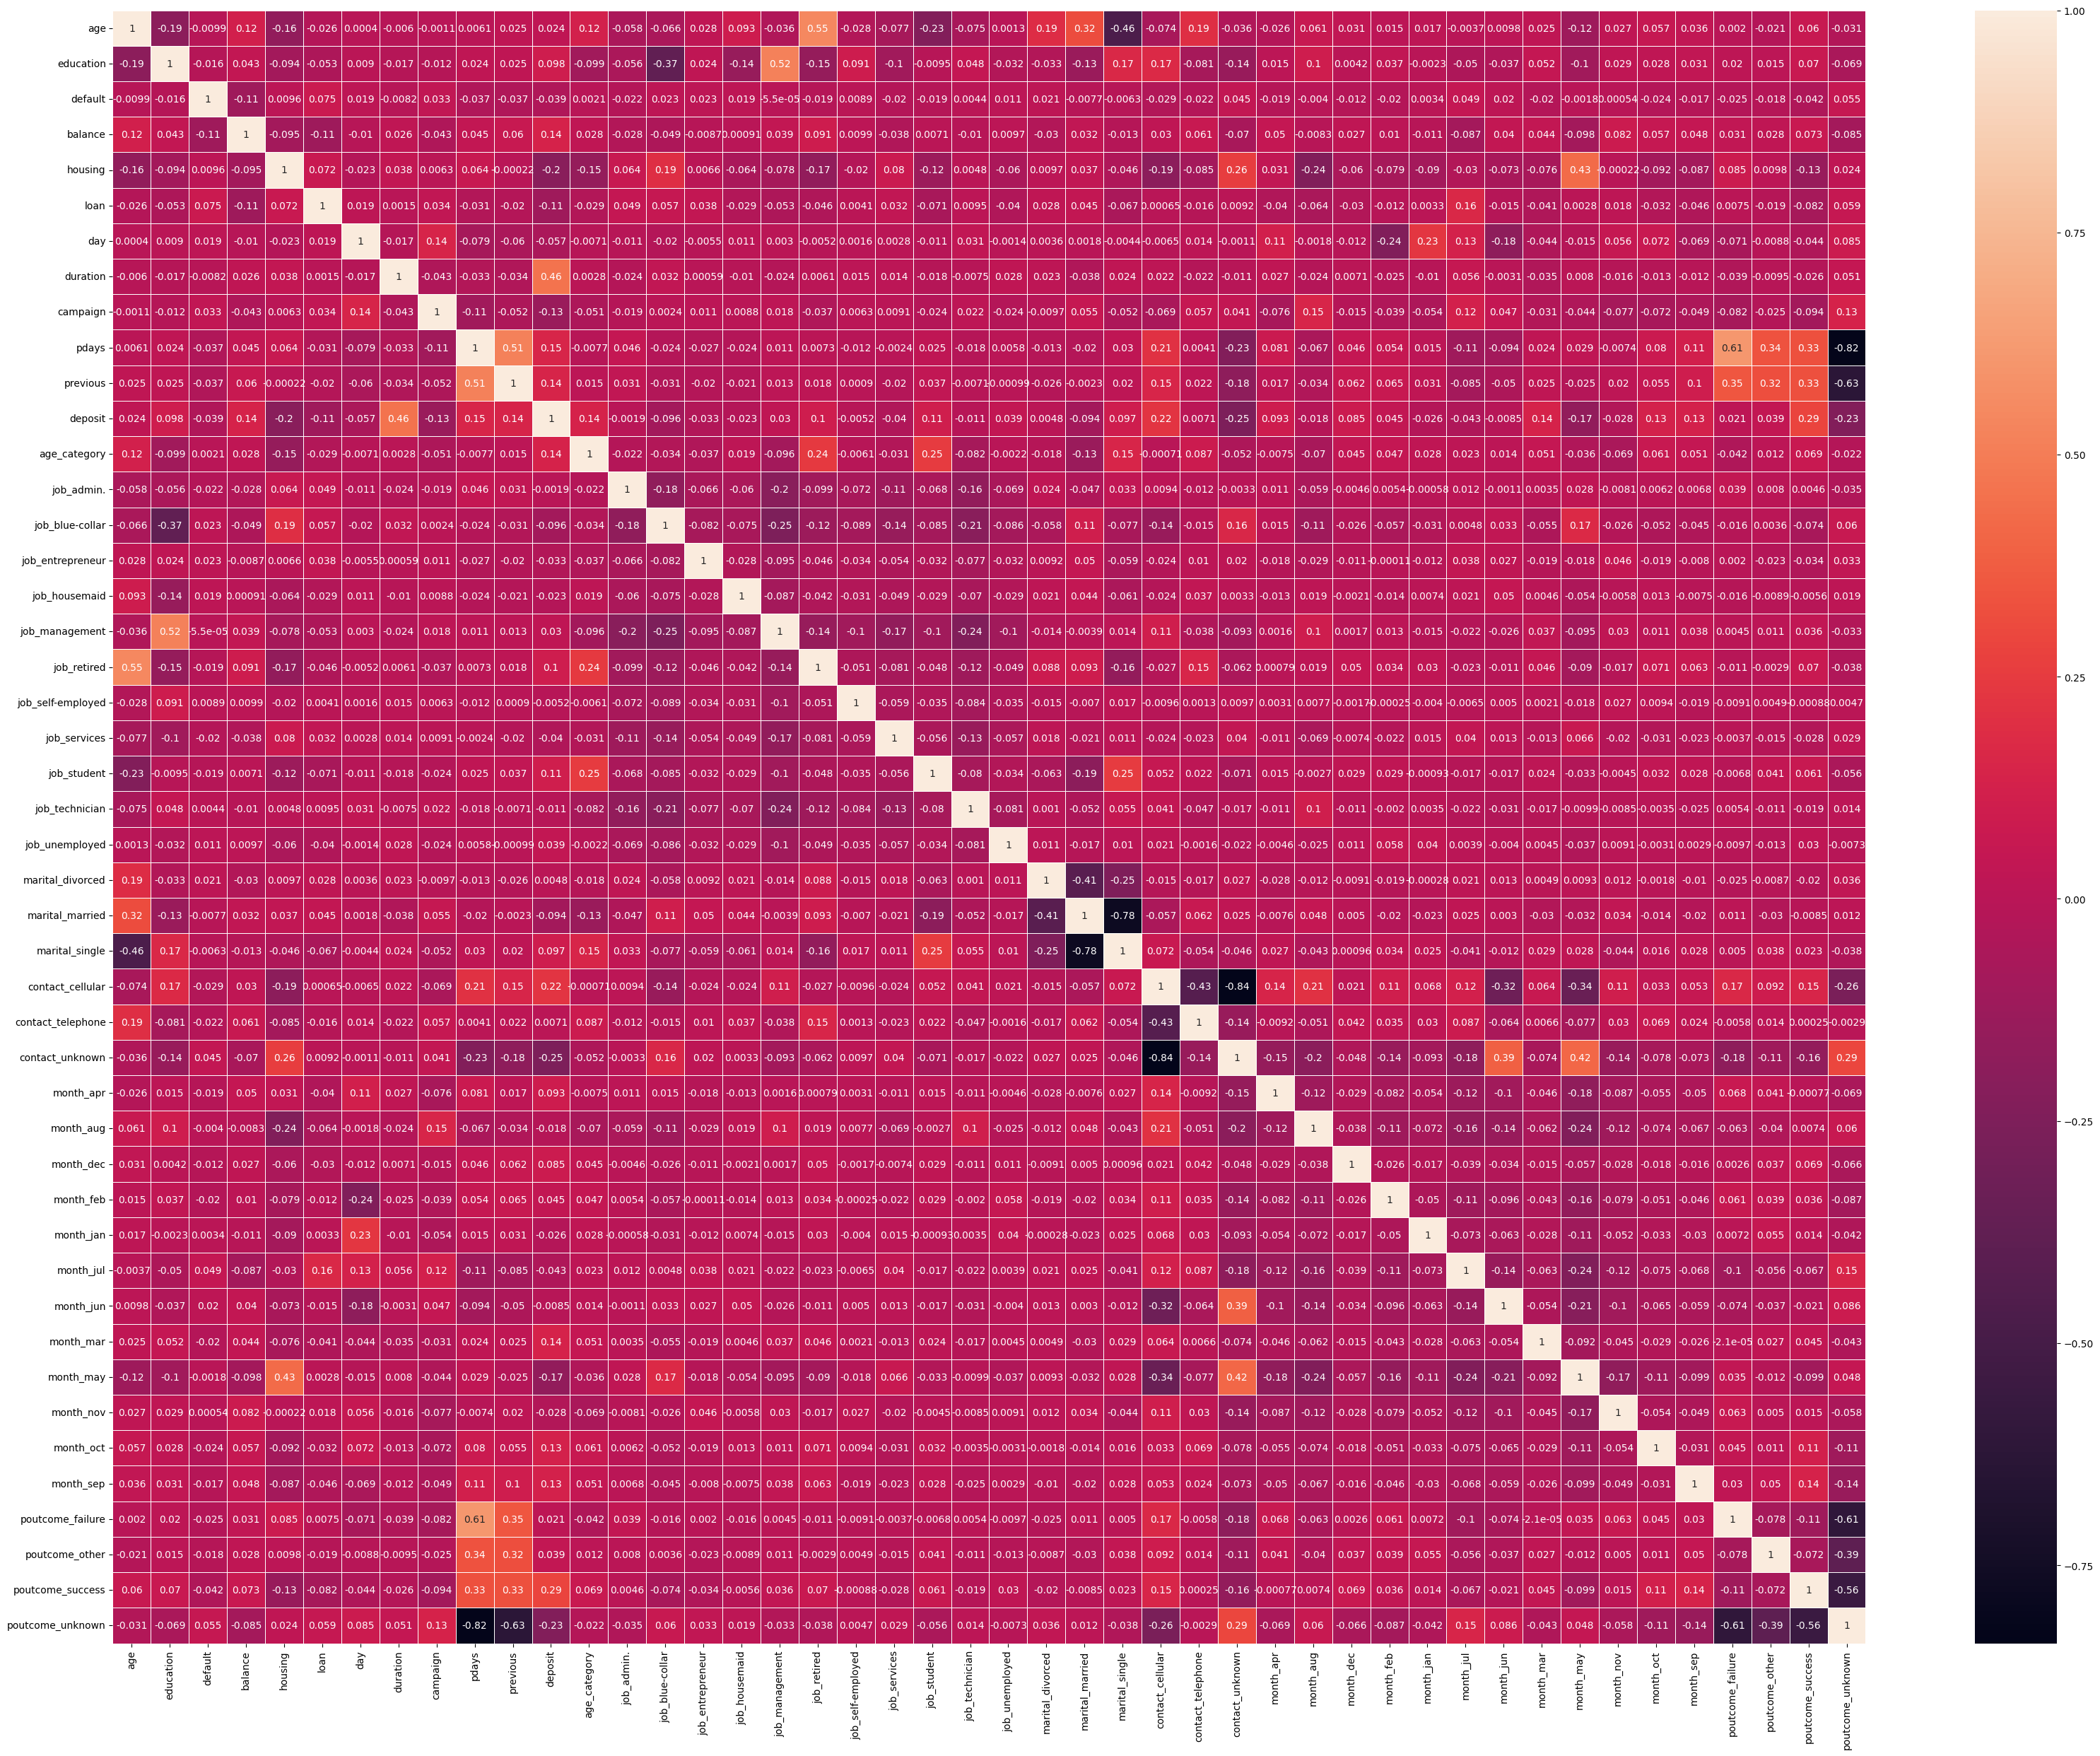

In [109]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(40,30))
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=.5, ax=ax)

### Задания 7 и 8

In [110]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [111]:
# рассчитайте необходимые показатели
print(X_test.shape)

print(round(y_test.mean(), 2))

(3335, 45)
0.46


### Задание 9

In [112]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
 
sb_best = selector.get_feature_names_out().tolist()
sb_best



['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_category',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [113]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train[sb_best])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[sb_best].columns)

X_test_scaled = mm_scaler.transform(X_test[sb_best])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test[sb_best].columns)

print(round(X_test_scaled.iloc[:, 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [114]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=42)

log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [115]:
# обучите решающие деревья, настройте максимальную глубину
des_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    random_state=42
)

des_tree.fit(X_train_scaled, y_train)

y_train_pred = des_tree.predict(X_train_scaled)
y_test_pred = des_tree.predict(X_test_scaled)

print('train')
print(metrics.classification_report(y_train, y_train_pred))
print('test')
print(metrics.classification_report(y_test, y_test_pred))

train
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

test
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [116]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {  'min_samples_split': [2, 5, 7, 10],
                'max_depth': [3,5,7]
                  }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42),
    param_grid=param_grid,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train) 
y_test_pred = grid_search.predict(X_test_scaled)

print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}
f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [117]:
# обучите на ваших данных случайный лес
Ran_For = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

Ran_For.fit(X_train_scaled, y_train)
y_test_pred = Ran_For.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [118]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

Grad_Boost = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

Grad_Boost.fit(X_train_scaled, y_train)
y_test_pred = Grad_Boost.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [119]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)),
    ('lr', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)),
    ('gb', ensemble.GradientBoostingClassifier(learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42))
]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        solver='sag', 
        max_iter=1000, 
        random_state=42
    )
)

stack.fit(X_train_scaled, y_train)
y_test_pred = stack.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [120]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
best_by_gb = Grad_Boost.feature_importances_

lst = []
for i, feature in enumerate(X_test_scaled.columns):
    lst.append((feature, best_by_gb[i]))

print(sorted(lst, key=lambda x: x[1], reverse=True)[:3])

[('duration', 0.50198685987414), ('poutcome_success', 0.11626370100249661), ('contact_unknown', 0.07375973565167121)]


### Задания 6,7,8

In [123]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(random_state = 42)
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    return score


study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=30)

best_by_optuna = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
best_by_optuna.fit(X_train_scaled, y_train)
y_test_pred = best_by_optuna.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(best_by_optuna.score(X_test_scaled, y_test)))

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2024-03-11 19:50:00,107] A new study created in memory with name: RandomForestClassifier
[I 2024-03-11 19:50:00,714] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 156, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.
[I 2024-03-11 19:50:01,322] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 168, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.0.
[I 2024-03-11 19:50:01,931] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 197, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 1.0.
[I 2024-03-11 19:50:02,535] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 160, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 1.0.
[I 2024-03-11 19:50:03,140] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 184, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.0.
[I 2024-03-11 19:50:03,743] Trial 5 finish

f1_score на тестовом наборе: 0.82
accuracy на тестовом наборе: 0.83
